# 프로젝트: Multi classification

## 기본 셋팅
* 드라이브 마운트 
* 랜덤 시드 고정
* 파일 경로 설정

In [117]:
# from google.colab import drive
# drive.mount('/content/drive')

In [317]:
# library import 
import os 
from glob import glob

import random 
import tensorflow as tf
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Conv2D, Flatten, GlobalAveragePooling2D, Activation, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [119]:
# random seed 고정
def set_seeds(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)

In [120]:
SEED = 42
set_seeds(SEED)

In [121]:
!pwd

/home/aiffel-dj19/programmers


In [122]:
# 경로 바꾸기
# %cd /content/drive/MyDrive/programmers/

In [123]:
# data path 확인 
data_path = os.getcwd() + '/data1/'
print(data_path)

train_path = os.getcwd() + '/data1/train'
train_list = os. listdir(train_path) 
print(train_path)
print(train_list)

test_path = os.getcwd() + '/data1/test'
test_list = os. listdir(test_path)
print(test_path)
print(test_list)

/home/aiffel-dj19/programmers/data1/
/home/aiffel-dj19/programmers/data1/train
['guitar', 'horse', 'dog', 'elephant', 'person', 'house', 'giraffe']
/home/aiffel-dj19/programmers/data1/test
['guitar', 'horse', 'dog', 'elephant', 'person', 'house', 'giraffe']


## 데이터셋 확인 및 불러오기
* 데이터 셋은 art painting으로 구성되어 있으며 7개의 카테고리로 구분되어 있습니다. 7개의 카테고리로는 classes에서 정의한 dog, elephant, giraffe, guitar, horse, house, person를 포함합니다.
* 하나의 이미지의 사이즈는 [3(Channel) * 227(Width) * 227(Height)]이며 각 카테고리 별 예시 이미지는 아래에서 확인할 수 있습니다.
* 훈련 데이터는 art painting 1698장이며 테스트 데이터는 art painting 350장입니다.

In [124]:
# dataset 경로내 폴더 개수 및 class 확인
def cntFolders(ds_path):
    folders = glob(ds_path + '/*')
    print(f'{len(folders)}개의 폴더가 있습니다.')

    folders_list = os.listdir(ds_path)
    print(f'folders_list: {folders_list}')

In [125]:
cntFolders(train_path)

7개의 폴더가 있습니다.
folders_list: ['guitar', 'horse', 'dog', 'elephant', 'person', 'house', 'giraffe']


In [126]:
cntFolders(test_path)

7개의 폴더가 있습니다.
folders_list: ['guitar', 'horse', 'dog', 'elephant', 'person', 'house', 'giraffe']


In [127]:
# dataset내 class별 data 개수 확인
def cntImages(ds_path):
    train_imgs_len = []

    for category in os.listdir(ds_path):
        num_imgs = len(os.listdir(os.path.join(ds_path, category)))
        train_imgs_len.append(num_imgs)
        print(f'Total {category} images: {num_imgs}개')

    print(f'=> Total images: {np.sum(train_imgs_len)}개')

In [128]:
# train내 class별 data 개수 확인
cntImages(train_path)

Total guitar images: 134개
Total horse images: 151개
Total dog images: 329개
Total elephant images: 205개
Total person images: 399개
Total house images: 245개
Total giraffe images: 235개
=> Total images: 1698개


In [129]:
# test내 class별 data 개수 확인
cntImages(test_path)

Total guitar images: 50개
Total horse images: 51개
Total dog images: 50개
Total elephant images: 50개
Total person images: 50개
Total house images: 50개
Total giraffe images: 49개
=> Total images: 350개


Image path: /home/aiffel-dj19/programmers/data1/train/guitar/pic_022.jpg
Image Shape: (227, 227, 3)


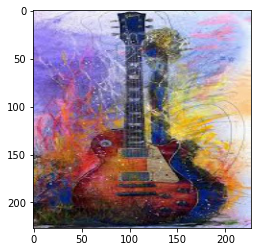

In [130]:
# data sample 확인하기
file_list = os.listdir(train_path + '/' + train_list[0])
# print(file_list)

img_path = train_path + '/' + train_list[0] + '/' + file_list[0]
img = tf.keras.preprocessing.image.load_img(img_path)
img_arr = tf.keras.preprocessing.image.img_to_array(img)

print(f'Image path: {img_path}')
print(f'Image Shape: {img_arr.shape}')

plt.imshow(img) 

## 데이터셋 입력 만들기 

In [131]:
# parameter setting 
batch_size = 64
img_height = 224 # img_arr.shape[0] # 227
img_width = 224 # img_arr.shape[1] # 227

print(f'B x IMG HEIGHT x IMG WIDTH = {batch_size} x {img_height} x {img_width}')

B x IMG HEIGHT x IMG WIDTH = 64 x 224 x 224


In [132]:
# data augmentation
train_datagen = ImageDataGenerator(rescale=1./255,                                   
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   fill_mode='nearest',
                                   validation_split=0.2
                                  )

test_datagen = ImageDataGenerator(rescale = 1./255)

In [367]:
# data load 
train_generator = train_datagen.flow_from_directory(
    train_path,
    subset="training",
    class_mode='categorical',
    seed=SEED,
    target_size=(img_height, img_width),
    batch_size=batch_size)

val_generator = train_datagen.flow_from_directory(
    train_path,
    subset="validation",
    class_mode='categorical',
    seed=SEED,
    target_size=(img_height, img_width),
    batch_size=batch_size)

test_generator = test_datagen.flow_from_directory(
    test_path,
    seed=SEED,
    target_size=(img_height, img_width))

Found 1361 images belonging to 7 classes.
Found 337 images belonging to 7 classes.
Found 350 images belonging to 7 classes.


In [368]:
type(train_generator), type(val_generator), type(test_generator)

(tensorflow.python.keras.preprocessing.image.DirectoryIterator,
 tensorflow.python.keras.preprocessing.image.DirectoryIterator,
 tensorflow.python.keras.preprocessing.image.DirectoryIterator)

In [369]:
# train class
classes = train_generator.class_indices
train_generator.class_indices

{'dog': 0,
 'elephant': 1,
 'giraffe': 2,
 'guitar': 3,
 'horse': 4,
 'house': 5,
 'person': 6}

In [370]:
# validation class
val_generator.class_indices

{'dog': 0,
 'elephant': 1,
 'giraffe': 2,
 'guitar': 3,
 'horse': 4,
 'house': 5,
 'person': 6}

In [371]:
# test class
test_generator.class_indices

{'dog': 0,
 'elephant': 1,
 'giraffe': 2,
 'guitar': 3,
 'horse': 4,
 'house': 5,
 'person': 6}

In [138]:
type(train_generator.class_indices)

dict

In [139]:
num_classes = len(train_generator.class_indices.values())

## 모델링

In [304]:
mobile = MobileNetV2(input_shape=(224, 224, 3),
                     include_top=False,
                     weights='imagenet')

In [305]:
efficient = EfficientNetB0(input_shape=(224,224,3), 
                           include_top=False,
                           weights='imagenet')

In [306]:
inception = InceptionV3(input_shape=(224,224,3), 
                        include_top=False,
                        weights='imagenet')

In [307]:
models = {'mobilenet': mobile, 'efficient': efficient, 'inception': inception}
base_model = models['inception']

In [308]:
base_model.trainable = False

In [310]:
from keras.models import Sequential

In [318]:
add_model = Sequential()
add_model.add(base_model)
add_model.add(GlobalAveragePooling2D())
add_model.add(Dropout(0.5))
add_model.add(Dense(num_classes, 
                    activation='softmax'))

In [319]:
model = add_model

In [320]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 7)                 14343     
Total params: 21,817,127
Trainable params: 14,343
Non-trainable params: 21,802,784
_________________________________________________________________


In [324]:
lr = 1e-4

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = lr),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [325]:
es = EarlyStopping(patience=4,verbose=1,restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.1,patience=3,verbose=1)

callbacks = [es, reduce_lr]

In [323]:
EPOCHS = 20

In [326]:
history = model.fit_generator(train_generator,
                              epochs=EPOCHS,
                              steps_per_epoch=train_generator.samples // batch_size,
                              validation_data=val_generator,
                              validation_steps=val_generator.samples // batch_size,
                              callbacks=callbacks
                             )

Epoch 1/20
21/21 [==============================] - 19s 762ms/step - loss: 2.7503 - accuracy: 0.1213 - val_loss: 2.0481 - val_accuracy: 0.2281
Epoch 2/20
21/21 [==============================] - 14s 705ms/step - loss: 2.4145 - accuracy: 0.1806 - val_loss: 1.9370 - val_accuracy: 0.2719
Epoch 3/20
21/21 [==============================] - 14s 689ms/step - loss: 2.2274 - accuracy: 0.2373 - val_loss: 1.8005 - val_accuracy: 0.3031
Epoch 4/20
21/21 [==============================] - 15s 695ms/step - loss: 2.2129 - accuracy: 0.2225 - val_loss: 1.7231 - val_accuracy: 0.3750
Epoch 5/20
21/21 [==============================] - 15s 703ms/step - loss: 2.0421 - accuracy: 0.2734 - val_loss: 1.6405 - val_accuracy: 0.3594
Epoch 6/20
21/21 [==============================] - 14s 675ms/step - loss: 2.0333 - accuracy: 0.2735 - val_loss: 1.5680 - val_accuracy: 0.4156
Epoch 7/20
21/21 [==============================] - 14s 681ms/step - loss: 1.8873 - accuracy: 0.3286 - val_loss: 1.4510 - val_accuracy: 0.4625

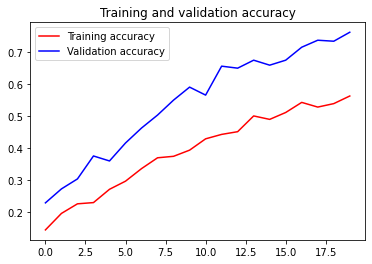

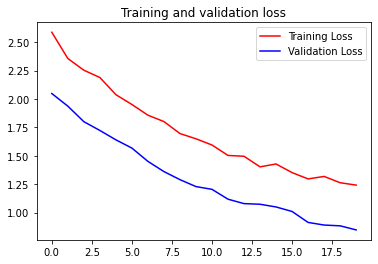

In [327]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [328]:
# evaluate
scores = model.evaluate_generator(test_generator, steps=5)
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

/home/aiffel-dj19/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


accuracy: 70.31%


In [329]:
!mkdir -p saved_model
# model.save('saved_model/mobilenetv2.h5')
model_name = 'inceptionv3'
model.save(f'saved_model/{model_name}.h5')

In [330]:
!ls ./saved_model

inceptionv3.h5	my_model  my_model.h5


In [331]:
load_model = tf.keras.models.load_model('saved_model/inceptionv3.h5')

In [372]:
predictions = load_model.predict_generator(test_generator, 
                                           steps = test_generator.n, 
                                           verbose=1)

/home/aiffel-dj19/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


350/350 [==============================] - 23s 2ms/step


In [373]:
np.argmax(predictions[0])

3

In [374]:
predictions.shape

(350, 7)

In [375]:
idx2name = [(i, n) for n, i in classes.items()]
idx2name

[(0, 'dog'),
 (1, 'elephant'),
 (2, 'giraffe'),
 (3, 'guitar'),
 (4, 'horse'),
 (5, 'house'),
 (6, 'person')]

In [376]:
idx2name[6]

(6, 'person')

## 제출 파일 만들기

In [377]:
!mkdir -p ./submit
!ls ./submit
!pwd

inceptionv3_answer.csv	test_answer_sample_.csv
/home/aiffel-dj19/programmers


In [378]:
submit_path = os.path.join(os.getcwd(), 'submit/')
submit_path

'/home/aiffel-dj19/programmers/submit/'

In [379]:
# 제출 파일 형식 확인
answer_df = pd.read_csv(submit_path + 'test_answer_sample_.csv', index_col=0)
answer_df.head()

,answer value
0,0
1,0
2,0
3,0
4,0


In [380]:
# filename to index
print(test_generator.filenames[0])
print(int(test_generator.filenames[0].strip('.jpg').split('/')[1]))

dog/0013.jpg
13


In [381]:
# index를 파일명에 맞게 재설정
numbering = [int(filename.strip('.jpg').split('/')[1]) for filename in test_generator.filenames]
len(numbering), min(numbering), max(numbering)

(350, 1, 350)

In [382]:
min(numbering), max(numbering)

(1, 350)

In [383]:
result_df = pd.DataFrame(index=numbering, columns=['answer value'])
result_df.head()

,answer value
13,NaN
18,NaN
25,NaN
29,NaN
35,NaN


In [384]:
type(predictions), predictions.shape

(numpy.ndarray, (350, 7))

In [385]:
pred_list = [np.argmax(pred) for pred in predictions]
len(pred_list)

350

In [386]:
result_df['answer value'] = pred_list
result_df.head()

,answer value
13,3
18,5
25,6
29,4
35,3


In [391]:
result_df = result_df.sort_index()
result_df.head(20)

,answer value
1,2
2,5
3,0
4,2
5,2
6,1
7,0
8,1
9,5
10,6


In [389]:
classes

{'dog': 0,
 'elephant': 1,
 'giraffe': 2,
 'guitar': 3,
 'horse': 4,
 'house': 5,
 'person': 6}

In [390]:
result_df.to_csv(f'{submit_path}{model_name}_answer.csv')
print(f'{submit_path}{model_name}_answer.csv')

/home/aiffel-dj19/programmers/submit/inceptionv3_answer.csv
